In [ ]:
 #Link to colab notebook:
#https://colab.research.google.com/drive/1Rr18sWEZ_9EIH3whtOAsWh3lkF8oobhH?usp=sharing


%matplotlib inline
%tensorflow_version 1.x

!pip install wordninja
!pip install langdetect
!pip install geopandas
!pip install -q gpt-2-simple

import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt 
import re
import nltk
import wordninja
import requests
import geopandas as gpd
import random
import ast
import tensorflow as tf
import os
import time
import gpt_2_simple as gpt2

from geopandas import GeoDataFrame
from shapely.geometry import Point
from lxml import html
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from google.colab import drive
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from langdetect import detect
from nltk import FreqDist
from nltk import classify
from nltk import NaiveBayesClassifier
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
from datetime import datetime
from google.colab import files

#wordnet is a lexical database for the English language that determines the base word. 
nltk.download('wordnet')
#averaged_perceptron_tagger helps determine the context of a word in a sentence.
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('brown')
nltk.download('stopwords')

drive.mount('/content/drive')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Our File Locations

In [ ]:
# Delaney 

#Cal Poly/Senior Year/DATA 301/Project
Trump = pd.read_csv("/content/drive/MyDrive/301project/trump.csv", lineterminator='\n')
Biden = pd.read_csv("/content/drive/MyDrive/301project/biden.csv", lineterminator='\n')

#Language Detection

In [ ]:
initialTrump = pd.read_csv("/content/drive/My Drive/301project/hashtag_donaldtrump.csv", lineterminator='\n')
initialBiden = pd.read_csv("/content/drive/My Drive/301project/hashtag_joebiden.csv", lineterminator='\n')

In [ ]:
#remove links and '#'s from each tweet to improve detection accuracy
def refactorTweets(row):
  newRow = re.sub(r'^https?:\/\/.*[\r\n]*', '', row, flags=re.MULTILINE)
  newRow = newRow.replace("#", "").replace("_", " ").replace("@","")
  return newRow
#get language of each tweet if possible, if error due to no content, return N/A
def getLanguage(row):
  try: 
    lang = detect(row.tweet)
  except:
    lang = 'N/A'
  return lang

In [ ]:
initialTrump['tweet'] = initialTrump['tweet'].apply(refactorTweets)
initialBiden['tweet'] = initialBiden['tweet'].apply(refactorTweets)

In [ ]:
initialTrump['lang'] = initialTrump.apply(getLanguage,axis=1)
initialBiden['lang'] = initialBiden.apply(getLanguage,axis=1)

In [ ]:
initialTrump.to_csv('trump.csv')
initialBiden.to_csv('biden.csv')

Import the datasets after adding language column from previous code

In [ ]:
Trump = pd.read_csv("/content/drive/My Drive/301project/trump.csv", lineterminator='\n')
Biden = pd.read_csv("/content/drive/My Drive/301project/biden.csv", lineterminator='\n')

## Data Exploration and Feature Extraction

---



In [ ]:
# Set new columns which we know
Biden["is_Trump"] = 0
Trump["is_Trump"] = 1
Both = pd.concat([Trump, Biden])
Combined = pd.concat([Trump,Biden])

In [ ]:
#### Determine sides ####

bidenSupportWords = "BIDEN2020|Biden2020|biden2020|BIDEN 2020|biden 2020|Biden 2020"
trumpSupportWords = "TRUMP2020|Trump2020|trump2020|TRUMP 2020|Trump 2020|trump 2020"

# Decided on categorization by what Tweets contain because going by what users had
#   in their description results in too small of a dataset.
Both["lTweet"] = Both["tweet"].str.contains(bidenSupportWords)
Both["rTweet"] = Both["tweet"].str.contains(trumpSupportWords)

# Only keep rows which are one or the other by using XOR
Both = Both[(Both['lTweet'] == True) ^ (Both['rTweet'] == True)]

# 1 is Right 0 is Left
Both['side'] = (Both['rTweet'] == True)

In [ ]:
def create_numerical_column(df, column_name):
    items = df[column_name].unique()
    item_dict = {}
    unique_id = 0
    for item in items:
        if item not in item_dict:
            item_dict[item] = unique_id
            unique_id += 1

    df.loc[:, column_name + '_numerical'] = df.loc[:,column_name].map(lambda item: item_dict[item])
    return df

In [ ]:
# Get numerical columns for correlations
Both = create_numerical_column(Both, 'city')
Both = create_numerical_column(Both, 'state')
Both = create_numerical_column(Both, 'country')
Both = create_numerical_column(Both, 'source')
Both = create_numerical_column(Both, 'user_name')
Both = create_numerical_column(Both, 'user_screen_name')
Both = create_numerical_column(Both, 'lang')
Both = create_numerical_column(Both, 'continent')

##Exploration Visualizations

In [ ]:
def cleanTweet(tweet):
  return (str(tweet).replace('https','')).replace('dtype','')

In [ ]:
#get populations of states from wikipedia
statePops =requests.get('https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population')
statePopsTree = html.fromstring(statePops.content)
pops = pd.DataFrame(statePopsTree.xpath('//*[@id="mw-content-text"]/div[1]/table/tbody/tr/td[4]/text()')[0:], columns = ['population'])
pops.drop(pops.tail(6).index,inplace=True) 
pops['state'] = statePopsTree.xpath('//*[@id="mw-content-text"]/div[1]/table/tbody/tr/td[3]/a/text()')[0:]

In [ ]:
#turn strings into ints
def fixPops(pop):
  newPop = pop.replace(',', '')
  newPop = newPop.replace('\n','')
  return int(newPop)

pops['population'] = pops['population'].apply(fixPops)

In [ ]:
#get count of tweets from each state
stateCounts = Combined['state'].value_counts()
stateCounts = stateCounts.sort_values(ascending=False)
stateCounts = pd.DataFrame(stateCounts).reset_index()
stateCounts = stateCounts.rename(columns={"index": "state", "state": "tweet_count"})

In [ ]:
#get tweets per million for each state
tweetsByPop = pd.merge(pops,stateCounts,how='inner',on='state')
tweetsByPop['perMil'] = tweetsByPop.apply(lambda x : (x.tweet_count/x.population)*1000000,axis=1)
tweetsByPop = tweetsByPop.sort_values(by=['tweet_count'],ascending=False)
tweetsByPop = tweetsByPop.drop(30)
#adding how each state voted in 2020
tweetsByPop['color'] = ['blue','blue','red','red','blue','blue','blue','blue','red','blue','blue','blue','blue','blue','red','red','blue','red','blue','blue','red','red','blue','blue','blue','red','red','blue','red','red','red','red','blue','blue','red','red','red','red','red','blue','blue','red','blue','red','red','blue','red','red','red','red']
tweetsByPop

,population,state,tweet_count,perMil,color
3,19453561,New York,37484,1926.845167,blue
0,39512223,California,34633,876.513579,blue
1,28995881,Texas,14225,490.586922,red
2,21477737,Florida,12023,559.788957,red
5,12671821,Illinois,7936,626.271473,blue
4,12801989,Pennsylvania,6139,479.534860,blue
7,10617423,Georgia,4697,442.386067,blue
14,6949503,Massachusetts,4562,656.449821,blue
6,11689100,Ohio,4157,355.630459,red
12,7614893,Washington,3484,457.524485,blue


###word cloud

(-0.5, 399.5, 199.5, -0.5)

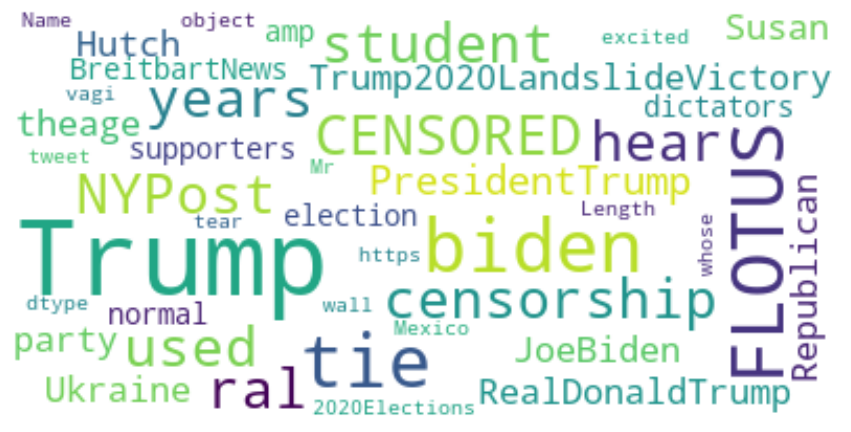

In [ ]:
wc = WordCloud(max_font_size=50,max_words=150,background_color='white').generate(str(Combined.loc[Combined['lang']=='en']['tweet']))
plt.subplots(figsize=(15,15))
plt.style.use('dark_background')
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')

###Pie chart of percent of tweets from each state

([<matplotlib.patches.Wedge at 0x7fb2e7fc4160>,
 [Text(0.8351092275729767, 0.7159557095396799, 'New York'),
  Text(-0.5287994100616006, 0.9645575067970305, 'California'),
  Text(-1.0883719566804566, 0.1595195408454856, 'Texas'),
  Text(-1.033025728178456, -0.37796540175176235, 'Florida'),
  Text(-0.8210640528711386, -0.7320203693086828, 'Illinois'),
  Text(-0.599644693648671, -0.922185578600637, 'Pennsylvania'),
  Text(-0.39948343456229213, -1.0248965730796036, 'Georgia'),
  Text(-0.21486959481455628, -1.0788100190599959, 'Massachusetts'),
  Text(-0.03491434352471899, -1.099445764290462, 'Ohio'),
  Text(0.12373667457784232, -1.0930184057756838, 'Washington'),
  Text(0.26590737773063955, -1.0673768155943877, 'Nevada'),
  Text(0.400645939166898, -1.0244426930917485, 'Arizona'),
  Text(0.518960558731982, -0.9698865595937441, 'Oregon'),
  Text(0.6206181504490575, -0.9082032323952558, 'Colorado'),
  Text(0.7054630248187101, -0.843991659090086, 'North Carolina'),
  Text(0.7758737896098403, -

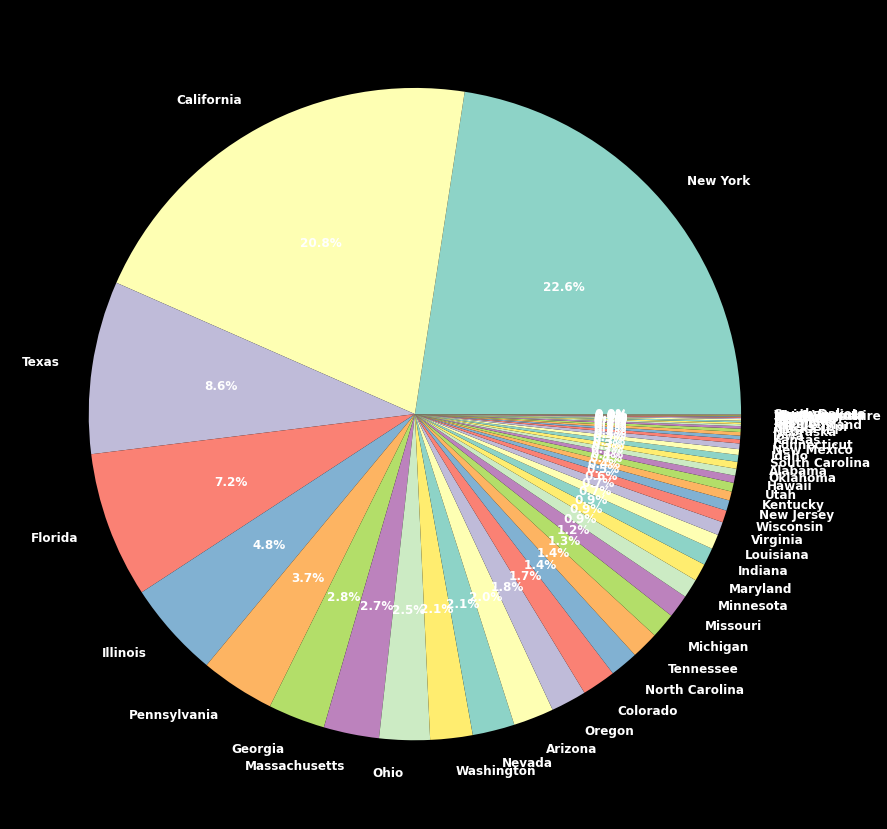

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
plt.style.use('dark_background')
plt.subplots(figsize=(15,15))
plt.pie(tweetsByPop['tweet_count'],labels=tweetsByPop['state'], autopct='%1.1f%%')

###Bar chart of tweets for each state

<BarContainer object of 50 artists>

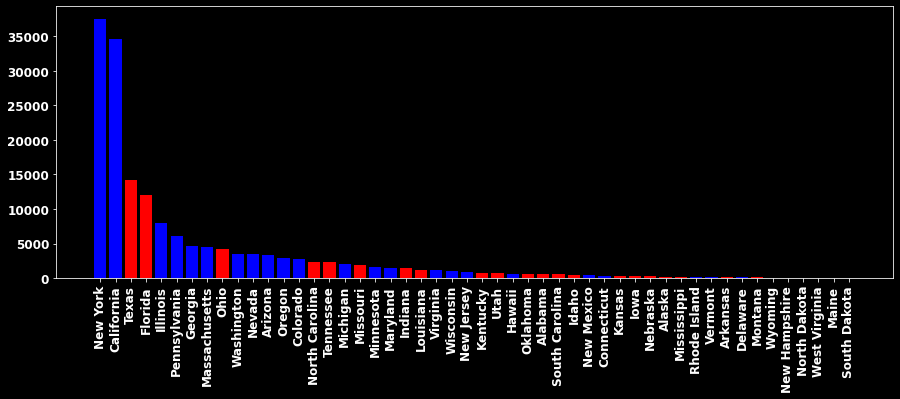

In [ ]:
plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
plt.style.use('dark_background')
plt.bar(tweetsByPop['state'],tweetsByPop['tweet_count'],color=tweetsByPop['color'])

### Bar chart of tweets per million for each state

<BarContainer object of 50 artists>

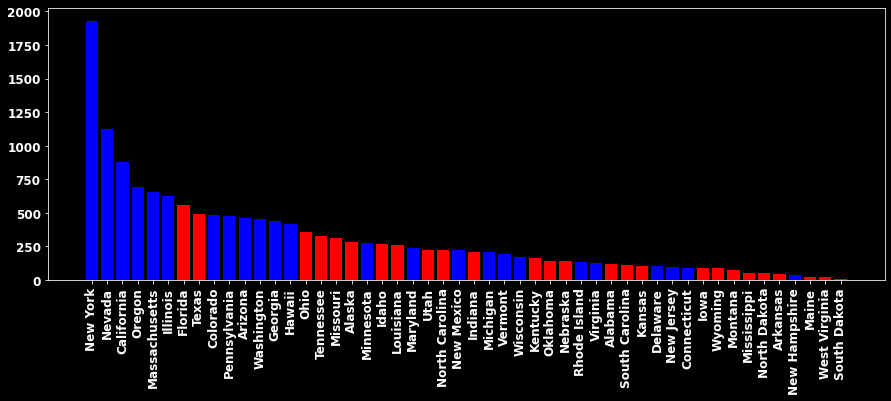

In [ ]:
plt.subplots(figsize=(15,5))
plt.style.use('dark_background')
plt.xticks(rotation=90)
tweetsByPop = tweetsByPop.sort_values(by=['perMil'],ascending=False)
plt.bar(tweetsByPop['state'],tweetsByPop['perMil'],color=tweetsByPop['color'])

### Top 100 users with the most tweets

<BarContainer object of 100 artists>

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127987 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127752 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128406 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127996 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128509 missing from current font.
  fon

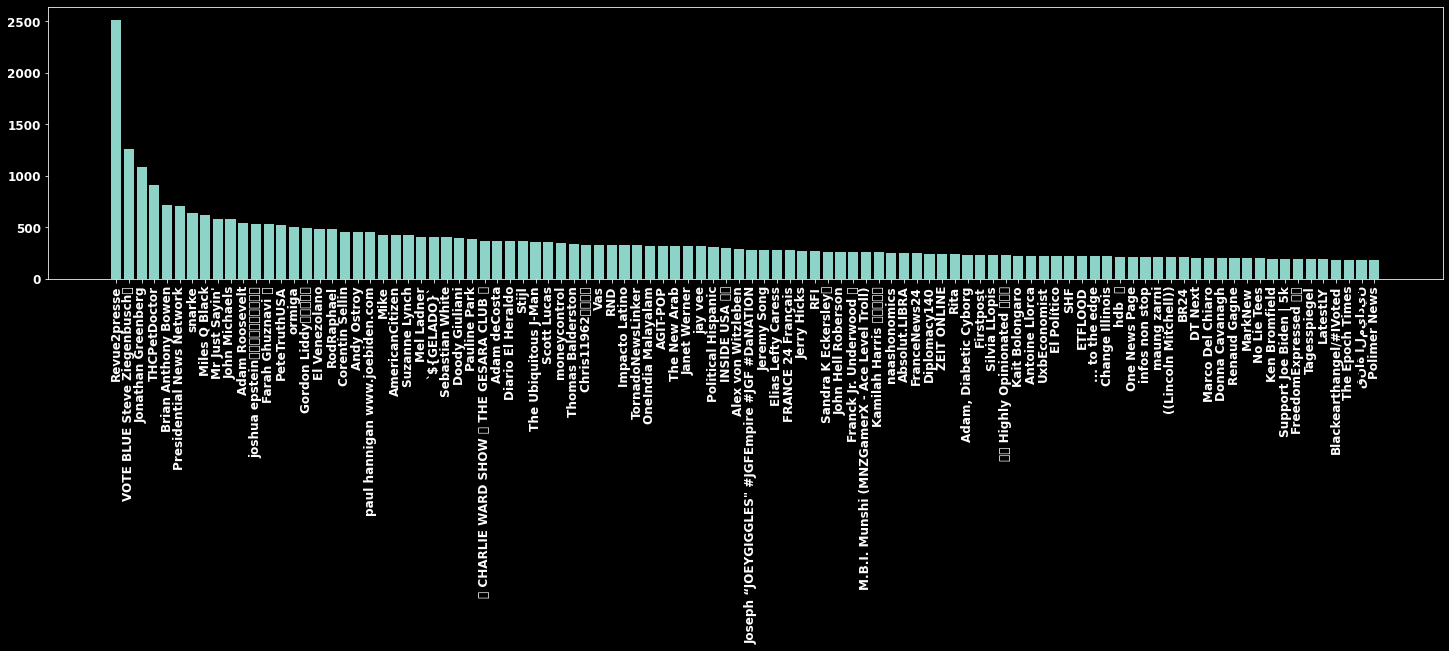

In [ ]:
userCounts = Combined['user_name'].value_counts().nlargest(100)
plt.subplots(figsize=(25,5))
plt.xticks(rotation=90)
plt.style.use('dark_background')
plt.bar(userCounts.index,userCounts.values)

### Graphing each tweet on a map
#### blue dots are trump2020 tweets and red are biden2020

In [ ]:
bidenSupport = "BIDEN2020|Biden2020|biden2020|BIDEN 2020|biden 2020|Biden 2020"
trumpSupport = "TRUMP2020|Trump2020|trump2020|TRUMP 2020|Trump 2020|trump 2020"

# Decided on categorization by what Tweets contain because going by what users had
#   in their description results in too small of a dataset.
Combined["lTweet"] = Combined["tweet"].str.contains(bidenSupport)
Combined["rTweet"] = Combined["tweet"].str.contains(trumpSupport)

#Only keep rows which are one or the other by using XOR
Bo = Combined[(Combined['lTweet'] == True) ^ (Combined['rTweet'] == True)]

# 1 is Right 0 is Left
Bo['side'] = (Bo['rTweet'] == True)

lft = Bo.loc[Bo['side'] == 0]
rht = Bo.loc[Bo['side'] == 1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


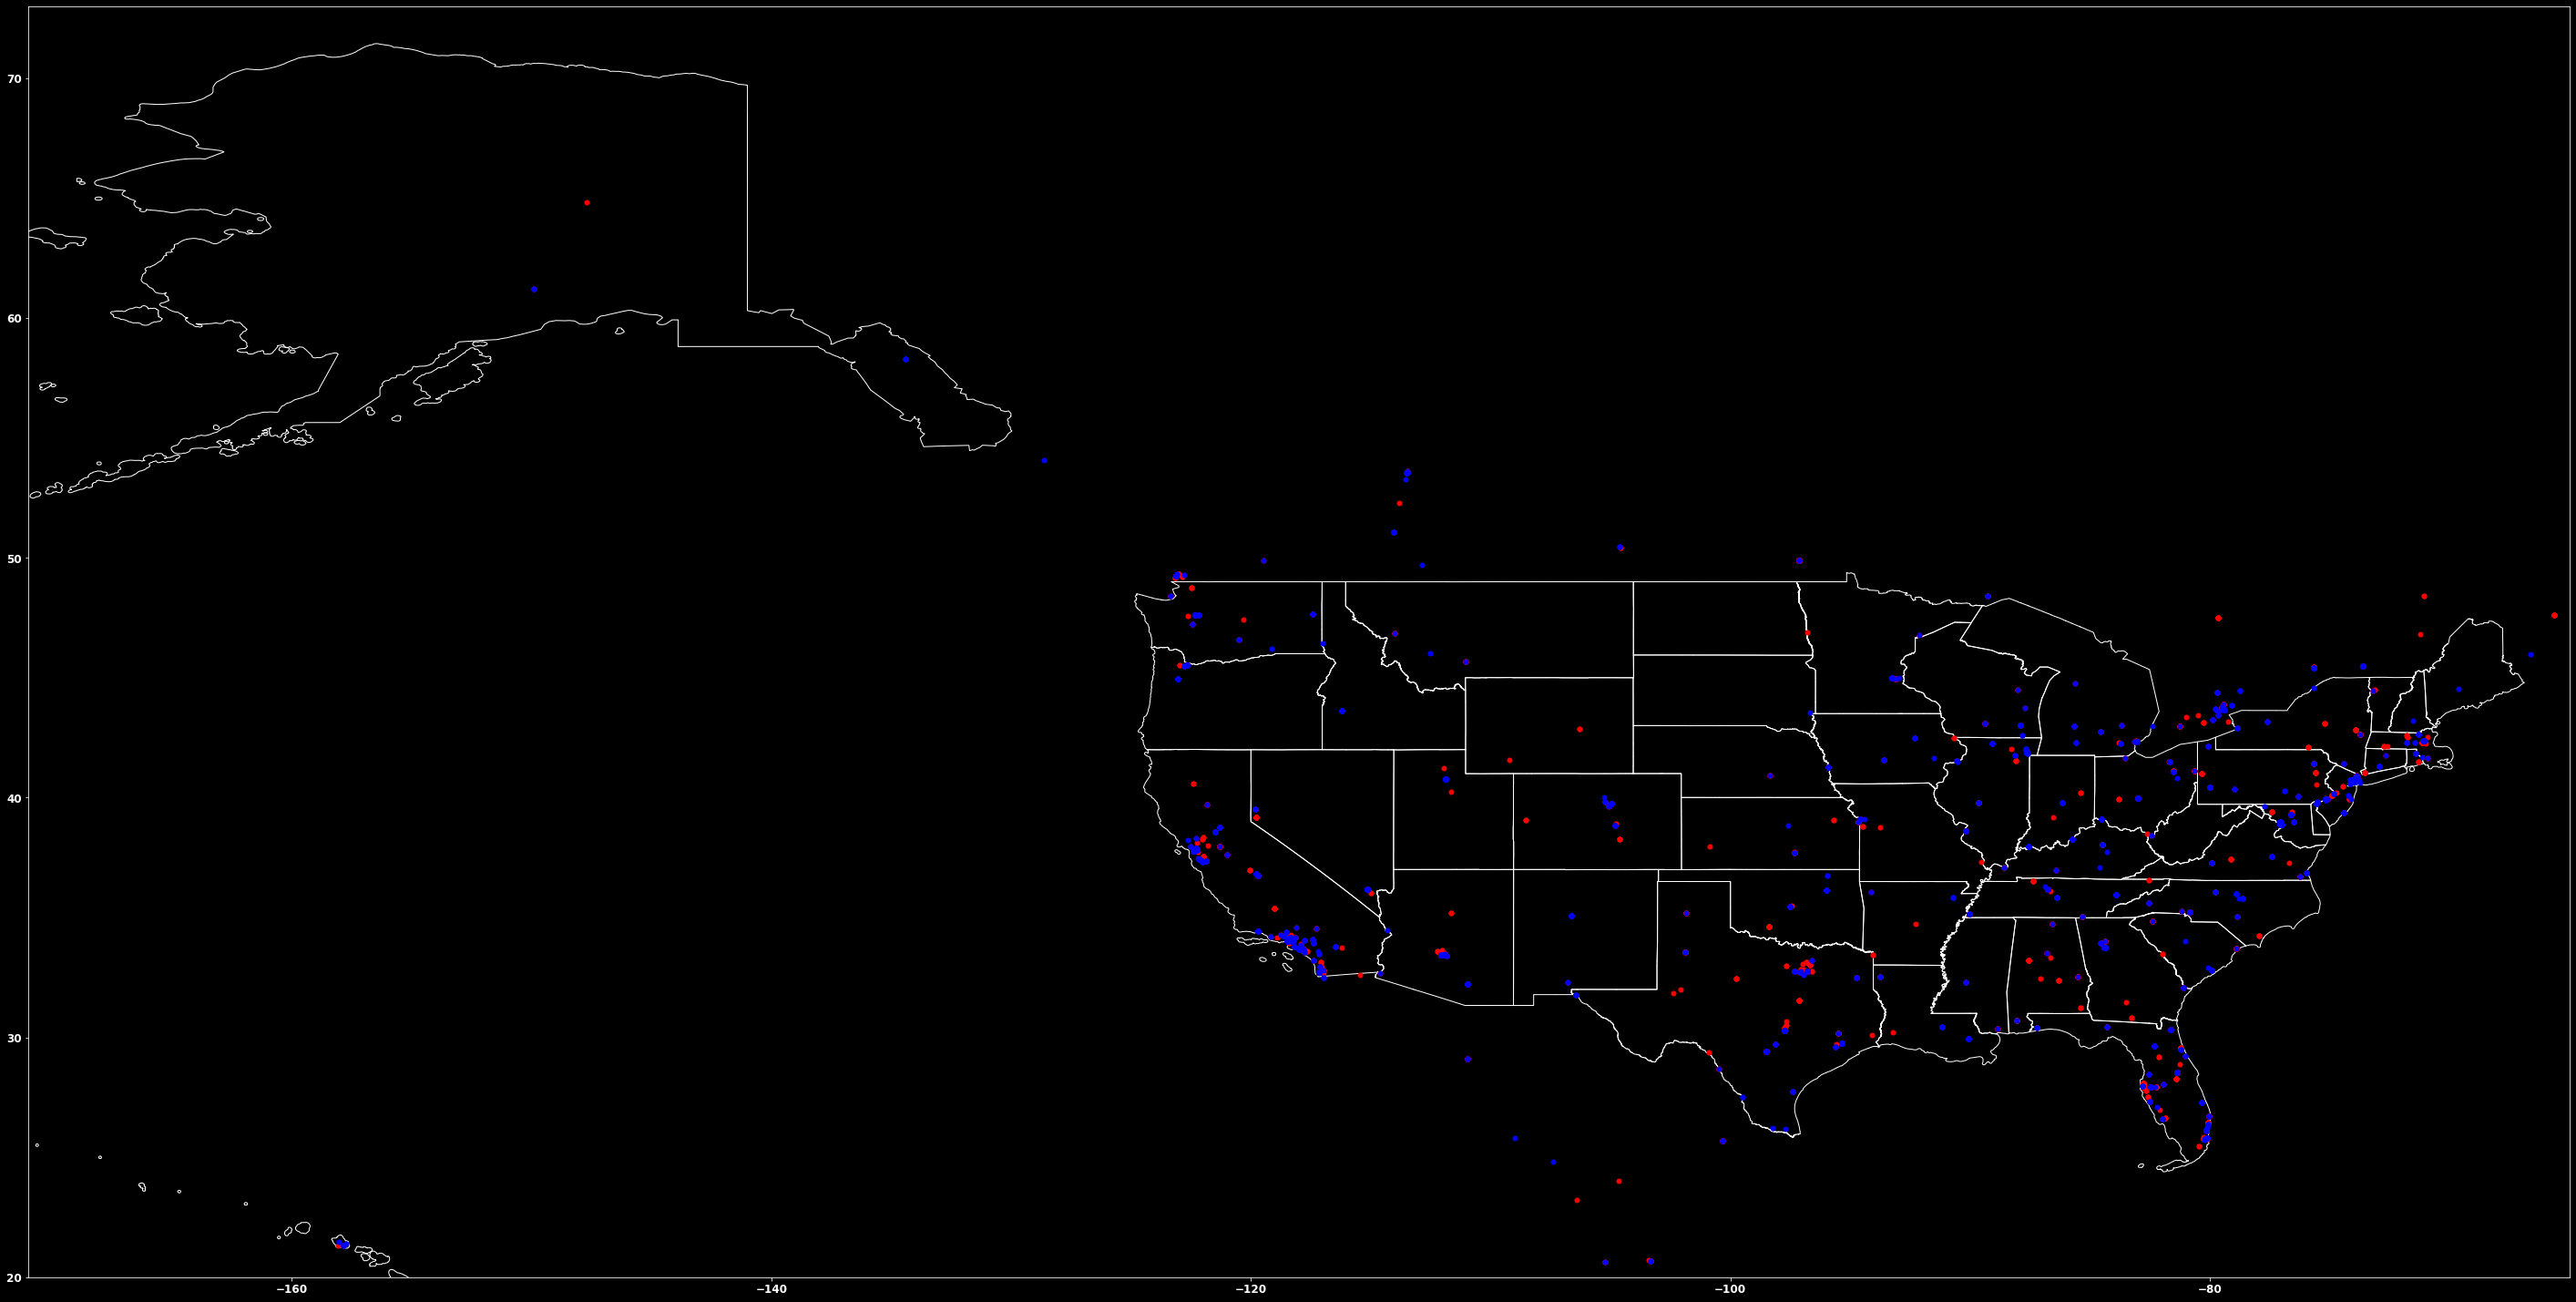

In [ ]:
geolft = [Point(xy) for xy in zip(lft['long'], lft['lat'])]
gdflft = GeoDataFrame(lft, geometry=geolft)

georht = [Point(xy) for xy in zip(rht['long'], rht['lat'])]
gdfrht = GeoDataFrame(rht, geometry=georht)

world = gpd.read_file('/content/drive/MyDrive/tl_2017_us_state.shp',SHAPE_RESTORE_SHX="YES")

base = world.plot(figsize=(50, 50),facecolor="none", edgecolor="white")
base.set_ylim(20,73)
base.set_xlim(-171,-65)
gdfrht.plot(ax=base, marker='o', color='red', markersize=25, alpha = 1)
gdflft.plot(ax=base, marker='o', color='blue', markersize=25, alpha = 1)

In [ ]:
wc = WordCloud(max_font_size=50,max_words=50,background_color='white').generate(str(lft.loc[lft['lang']=='en']['tweet']))
plt.subplots(figsize=(15,15))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

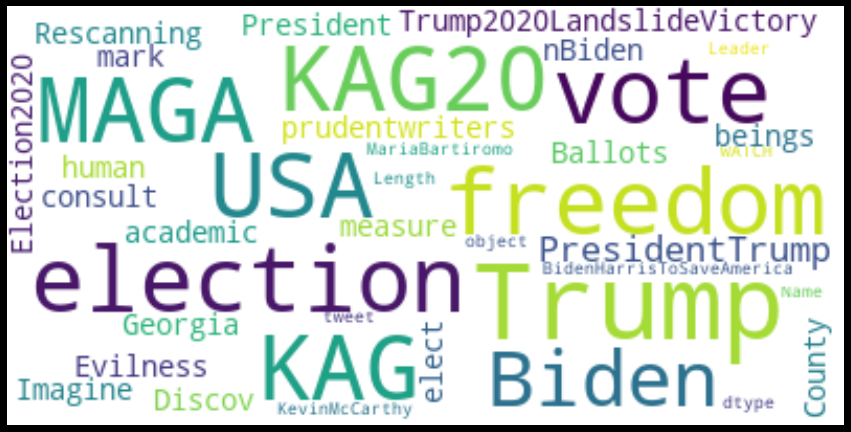

In [ ]:
wc = WordCloud(max_font_size=50,max_words=50,background_color='white').generate(str(rht.loc[rht['lang']=='en']['tweet']))
plt.subplots(figsize=(15,15))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')

### Most common languages in tweets

<BarContainer object of 53 artists>

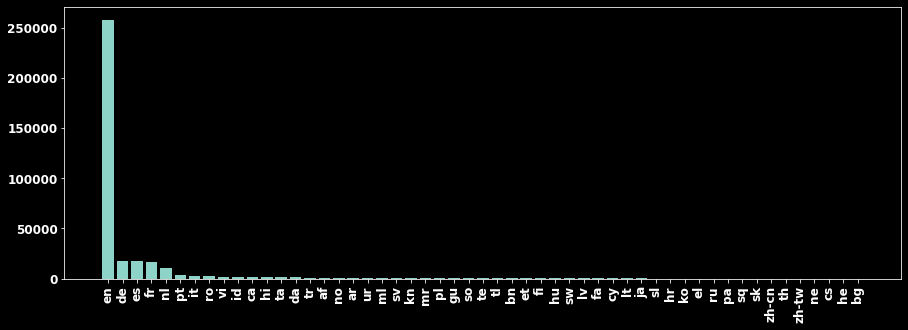

In [ ]:
plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
plt.bar(Combined['lang'].value_counts().index,Combined['lang'].value_counts().values)

# Sentiment Analysis 

## Removing Non-ASCII Values




In [ ]:
Biden['tweet'] = Biden['tweet'].fillna("")
Trump['tweet'] = Trump['tweet'].fillna("")

In [ ]:
def remove_nonascii(df):
  cleaned_tweet = []
  for tweet in df['tweet']:
      # print ("Tweet", tweet)
      encoded_string = tweet.encode("ascii", "ignore")
      decode_string = encoded_string.decode()
      decode_string = re.sub(r'^https?:\/\/.*[\r\n]*', '', decode_string, flags=re.MULTILINE)
      decode_string = re.sub(r'http\S+', '', decode_string)

      cleaned_tweet.append(decode_string)
  return cleaned_tweet

In [ ]:
Biden['cleaned_Tweet'] = remove_nonascii(Biden)
Trump['cleaned_Tweet'] = remove_nonascii(Trump)

## Splitting Tweets, including hashtags, into Words

In [ ]:
Biden['words'] = Biden['cleaned_Tweet'].str.strip().str.split('[\W]+')
Trump['words'] = Trump['cleaned_Tweet'].str.strip().str.split('[\W]+')

In [ ]:
def hash_splitter(row):
  word_list = []
  for word in row['words']: 
    words = wordninja.split(word)
    for i in words:
      word_list.append(i)
  return word_list 

In [ ]:
Biden['split_words'] = Biden.apply(lambda row: hash_splitter(row), axis = 1)
Trump['split_words'] = Trump.apply(lambda row: hash_splitter(row), axis = 1)

## Removing Stop Words

In [ ]:
def remove_stop(df):
  stop_words = list(stopwords.words('english'))
  clean_words_all = []
  for i in range(0,len(df)):
    clean_words = []
    for word in df.iloc[i]['split_words']:
      # print("I", i, 'word', word)
      if(word.lower() not in stop_words and word != ''):
        clean_words.append(word.lower())
    # print(clean_words)
    clean_words_all.append(clean_words)
  return clean_words_all

In [ ]:
Biden['clean_words'] = remove_stop(Biden)
Trump['clean_words'] = remove_stop(Trump)

## Lemmatization

In [ ]:
def lemmatize_sentence(row):
  lemmatizer = WordNetLemmatizer()
  lemmatized_sentence = []

  for word, tag in pos_tag(row['clean_words']):
    if tag.startswith('NN'):
      pos = 'n'
    elif tag.startswith('VB'):
      pos = 'v'
    else:
      pos = 'a'
    lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
  return lemmatized_sentence

In [ ]:
Biden['lemmatized'] = Biden.apply(lambda row: lemmatize_sentence(row), axis = 1)
Trump['lemmatized'] = Trump.apply(lambda row: lemmatize_sentence(row), axis = 1)

## TextBlob Polarity

In [ ]:
def sentiment_avg(row, col): 
  blob = TextBlob(' '.join(row[col]))
  num_sentences = 0
  sentiment = 0
  for sentence in blob.sentences:
    # print(sentence)
    num_sentences += 1
    sentiment += sentence.sentiment.polarity
  if num_sentences == 0:
    out = 0
  else:
    out = sentiment/num_sentences
  return out

In [ ]:
# finding sentiment value based on lemmatized words in each tweet 
Biden['lemma_sentiment'] = Biden.apply(lambda row: sentiment_avg(row, 'lemmatized'), axis = 1)
Trump['lemma_sentiment'] = Trump.apply(lambda row: sentiment_avg(row, 'lemmatized'), axis = 1)

In [ ]:
# finding sentiment value based on cleaned words in each tweet 
Biden['sentiment'] = Biden.apply(lambda row: sentiment_avg(row, 'clean_words'), axis = 1)
Trump['sentiment'] = Trump.apply(lambda row: sentiment_avg(row, 'clean_words'), axis = 1)

In [ ]:
# sentiment based on original, uncleaned, tweets
def sentiment_avg_tweet(row): 
  blob = TextBlob(row['tweet'])
  num_sentences = 0
  sentiment = 0
  for sentence in blob.sentences:
    # print(sentence)
    num_sentences += 1
    sentiment += sentence.sentiment.polarity
  if num_sentences == 0:
    out = 0
  else:
    out = sentiment/num_sentences
  return out

Biden['sentiment_tweet_plain'] = Biden.apply(lambda row: sentiment_avg_tweet(row), axis = 1)
Trump['sentiment_tweet_plain'] = Trump.apply(lambda row: sentiment_avg_tweet(row), axis = 1)

In [ ]:
Both = pd.concat([Biden, Trump])

In [ ]:
Biden['lemma_sentiment'].describe()

count    155950.000000
mean          0.107378
std           0.279008
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.200000
max           1.000000
Name: lemma_sentiment, dtype: float64

In [ ]:
Trump['lemma_sentiment'].describe()

count    189277.000000
mean          0.058273
std           0.265358
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.166667
max           1.000000
Name: lemma_sentiment, dtype: float64

In [ ]:
Both['lemma_sentiment'].describe()

count    345227.000000
mean          0.080455
std           0.272706
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.200000
max           1.000000
Name: lemma_sentiment, dtype: float64

In [ ]:
import scipy.stats as stats

#perform two sample t-test with equal variances
stats.ttest_ind(a=Biden['lemma_sentiment'], b=Trump['lemma_sentiment'], equal_var=False)

Ttest_indResult(statistic=52.61047138469015, pvalue=0.0)

In [ ]:
# Biden.to_csv('/content/drive/MyDrive/Cal Poly/Senior Year/DATA 301/Project/301project/Biden_Sentiment.csv',sep='\t')
# Trump.to_csv('/content/drive/MyDrive/Cal Poly/Senior Year/DATA 301/Project/301project/Trump_Sentiment.csv',sep='\t')

In [ ]:
# to read in these data sets 
# Biden = pd.read_csv('/content/drive/MyDrive/Cal Poly/Senior Year/DATA 301/Project/301project/Biden_Sentiment.csv',sep='\t')
# Trump = pd.read_csv('/content/drive/MyDrive/Cal Poly/Senior Year/DATA 301/Project/301project/Trump_Sentiment.csv',sep='\t')

# Frequency Distributions of all Words found in each file

In [ ]:
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

B_all_pos_words = get_all_words(Biden['lemmatized'])
T_all_pos_words = get_all_words(Trump['lemmatized'])

In [ ]:
B_freq_dist_pos = FreqDist(B_all_pos_words)
T_freq_dist_pos = FreqDist(T_all_pos_words)

In [ ]:
freq_Biden = pd.DataFrame.from_dict(B_freq_dist_pos, orient='index')
freq_Biden.columns = ['Frequency']
freq_Biden.index.name = 'Term'
freq_Biden.sort_values(by = "Frequency", ascending= False)

,Frequency
Term,
biden,247978
2020,105394
joe,101706
trump,99942
election,80474
...,...
allende,1
delara,1
yahtzee,1


In [ ]:
freq_Trump = pd.DataFrame.from_dict(T_freq_dist_pos, orient='index')
freq_Trump.columns = ['Frequency']
freq_Trump.index.name = 'Term'
freq_Trump.sort_values(by = "Frequency", ascending= False)

,Frequency
Term,
trump,298643
2020,103331
biden,91799
election,86070
donald,56209
...,...
krall,1
verifies,1
merkur,1


# Naive Bayes Classifier

In [ ]:
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

Biden_tokens_for_model = get_tweets_for_model(Biden['lemmatized'])
Trump_tokens_for_model = get_tweets_for_model(Trump['lemmatized'])

In [ ]:
Biden_dataset = [(tweet_dict, "Biden") for tweet_dict in Biden_tokens_for_model]

Trump_dataset = [(tweet_dict, "Trump") for tweet_dict in Trump_tokens_for_model]

dataset = Biden_dataset + Trump_dataset

random.shuffle(dataset)

In [ ]:
train_data = dataset[:284670]
test_data = dataset[284670:]

In [ ]:
classifier = NaiveBayesClassifier.train(train_data)

In [ ]:
print("Accuracy is:", classify.accuracy(classifier, test_data))
print(classifier.show_most_informative_features(10))

Accuracy is: 0.747692256881946
Most Informative Features
                homicide = True            Trump : Biden  =    421.6 : 1.0
               negligent = True            Trump : Biden  =    181.2 : 1.0
                workload = True            Biden : Trump  =    108.0 : 1.0
                   biden = None            Trump : Biden  =     55.5 : 1.0
                folklore = True            Biden : Trump  =     45.3 : 1.0
                   trump = None            Biden : Trump  =     40.8 : 1.0
                      wt = True            Biden : Trump  =     38.9 : 1.0
                   kappa = True            Biden : Trump  =     38.4 : 1.0
                     508 = True            Trump : Biden  =     33.8 : 1.0
                  jangle = True            Trump : Biden  =     33.8 : 1.0
None


In [ ]:
# classifier.show_most_informative_features(200)

##TF-IDF

In [ ]:
def make_docs(df):
  result = []
  for i in range(0,len(df)):
    for word in df.iloc[i]['split_words']:
      result.append((i,word))
  return result
      
def tfidf(df):      
  result = make_docs(df)
  words = pd.DataFrame(result,columns=['document','word'])
  counts = words.groupby('document')['word'].value_counts().to_frame().rename(columns={'word':'frequency'})
  maxFrequency = counts.groupby('document').max().rename(columns={'frequency':'maxFr'}) 
  tf = counts.join(maxFrequency)
  tf['tf'] = tf['frequency']/tf['maxFr']
  numDocuments = len(df)
  docFrequency = words.groupby('word')['document'].nunique().to_frame().rename(columns={'document':'df'})
  docFrequency['idf'] = np.log2(numDocuments/docFrequency['df'].values)
  r = tf.join(docFrequency)
  r['tfidf'] = r['tf']*r['idf']
  return r

In [ ]:
biden_tfidf = tfidf(Biden)
trump_tfidf = tfidf(Trump)

In [ ]:
queries2 = biden_tfidf.rename(columns = {'tfidf':'tfidf_query'})
docs2 = trump_tfidf.rename(columns = {'tfidf':'tfidf_doc'})

In [ ]:
#too much data so take a sample of it
queries2 = queries2.sample(n=250)
docs2 = docs2.sample(n=250)

In [ ]:
def computeDistance(query, document): 
  d = docs2.loc[document][['tfidf_doc']]
  q = queries2.loc[query][['tfidf_query']]
  result = pd.merge(d, q, on = "word")

  if result.shape[0] != 0:
    dLength = ((d['tfidf_doc']**2).sum())**.5
    qLength = ((q['tfidf_query']**2).sum())**.5
    result['result']=result['tfidf_doc']*result['tfidf_query']
    return result['result'].sum()/(dLength*qLength)
  else:
    return 0

In [ ]:
similar = []
for query in queries2.groupby(level=0):
  for doc in docs2.groupby(level = 0):
    sim = computeDistance(query[0], doc[0])
    similar.append([int(query[0]), int(doc[0]), sim])

In [ ]:
similar_df = pd.DataFrame(similar, columns=["Query", "Document", "Similarity"])
similar_df['Similarity'].mean()

0.0034338680041681013

# Tweet Generation with Recurrent Neural Networks

### Basic RNN
#### Adapted from https://www.tensorflow.org/tutorials/text/text_generation

#####Training

In [ ]:
training_text = open('/content/drive/MyDrive/301project/uncleaned_english_tweets', 'r').read()

In [ ]:
# Create two lookup tables, one which maps index to character and the other which does vice versa
vocab = sorted(set(training_text))
char_to_ind = {char:ind for ind, char in enumerate(vocab)}
ind_to_char = np.array(vocab)
text_as_int = np.array([char_to_ind[c] for c in training_text])

In [ ]:
# Specify a target length for our tweets, then make them into sequences
tweet_length = 140
characters = tf.data.Dataset.from_tensor_slices(text_as_int)
tweets = characters.batch(tweet_length + 1, drop_remainder=True)

In [ ]:
# This neural net is trying to predict the next letter given the current letters. To do train this, we provide as input the first character up to the second to last
# character in the tweet. We provide as output the second character up to the last character. This is because the first prediction will use the first character from the input
# to try to predict the first character from the output (which is the second character of the tweet since we shifted the output by 1). This pattern of the input lagging the 
# output by 1 character is what allows us to train the neural net to try and predict the next character.
def get_input_output(tweet):
    input = tweet[:-1]
    output = tweet[1:]
    return input, output

dataset = tweets.map(get_input_output)
# It is important to batch and shuffle data so that our Neural Net doesn't run over the same pattern for every iteration and Epoch. 
# If we let it do that and didn't shuffle or batch, there is a high chance that we'd get stuck in a local minima each time.
# By shuffling, we give ourselves the opportunity to go down different paths in the data each time we train.
BATCH_SIZE = 256

# We need a buffer since TF doesn't keep the sequences in memory (as they could be infinite). Instead it
# maintains a buffer which in which it shuffles the data.
BUFFER_SIZE = 10000

new_dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
                             tf.keras.layers.GRU(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
                             tf.keras.layers.Dense(vocab_size)])
    return model

In [ ]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

training_model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=256)

In [ ]:
def loss_function(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

training_model.compile(optimizer='adam', loss=loss_function)

In [ ]:
# Set checkpoint directories
checkpoint_dir = './rnn_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
history = model.fit(new_dataset, epochs=300, initial_epoch=247, callbacks=[checkpoint_callback])

In [ ]:
model.save('rnn_checkpoint', overwrite=True, include_optimizer=True)
model.save_weights('rnn_checkpoint/training_weights.h5')

In [ ]:
#### Move from Colab Accessible to Drive ####
model.save_weights('rnn_checkpoint/training_weights.h5')
!cp -r rnn_checkpoint/ /content/drive/MyDrive/301project/RNN_Training

#####Testing

In [ ]:
#### Move from Drive to Colab Accessible ####

!cp -r /content/drive/MyDrive/301project/RNN_Training/rnn_checkpoint .

In [ ]:
testing_model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
testing_model.load_weights('rnn_checkpoint/training_weights.h5')
testing_model.build(tf.TensorShape([1, None]))

In [ ]:
def generate_text(model, start):
    num_generate = 120

    # Converting our start string to numbers (vectorizing)
    input_eval = [char_to_ind[s] for s in start]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(ind_to_char[predicted_id])

    return (start + ''.join(text_generated))

In [ ]:
print(generate_text(testing_model, 'Trump'))
print(generate_text(testing_model, 'Biden'))

TrumpBulteBuckcy 🌊
MAOC Vote
A rejudlificited urge Shat's Back FB  CrouDock out 8
CovidenTohypher Cas President Bidences Ob J
Bidenลভコลコ🎣コςςยভココ🕸ココココ🎣コ🎣コ🎣コココ🎣ココココココ🎣コভココลًコদコ🎣ココลココςςයςයদコςςයদココżদদコ🕸コココ🎣ココココココココココココลコż普ココ🎣コココココভココココココลコココลコココλコลココ🎣コξコς


### GPT2 Text Generation
#### Adapted from https://colab.research.google.com/drive/1VLG8e7YSEwypxU-noRNhsv5dW4NfTGce

#####Training


In [ ]:
gpt2.download_gpt2(model_name="124M")
sess = gpt2.start_tf_sess()

Fetching checkpoint: 1.05Mit [00:00, 190Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 79.6Mit/s]                                                   
Fetching hparams.json: 1.05Mit [00:00, 323Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 498Mit [00:02, 197Mit/s]                                   
Fetching model.ckpt.index: 1.05Mit [00:00, 164Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 140Mit/s]                                                 
Fetching vocab.bpe: 1.05Mit [00:00, 141Mit/s]                                                       


In [ ]:
gpt2.finetune(sess,
              dataset='/content/drive/MyDrive/301project/uncleaned_english_tweets',
              model_name='124M',
              steps=1000,
              restore_from='latest',
              run_name='124M_uncleaned_tweet',
              print_every=2,
              sample_every=5,
              save_every=10)

In [ ]:
#### Move from Colab Accessible to Drive ####
!mv ./checkpoint gpt2_checkpoint
!cp -r gpt2_checkpoint/ /content/drive/MyDrive/301project/GPT2_Training

#####Testing

In [ ]:
#### Move from Drive to Colab Accessible ####

!cp -r /content/drive/MyDrive/301project/GPT2_Training/gpt2_checkpoint .

In [ ]:
gpt2.load_gpt2(sess, run_name='/content/gpt2_checkpoint/124M_uncleaned_tweet')

In [ ]:
print(gpt2.generate(sess, run_name='/content/gpt2_checkpoint/124M_uncleaned_tweet', length=50, prefix='Trump'))
print(gpt2.generate(sess, run_name='/content/gpt2_checkpoint/124M_uncleaned_tweet', length=50, prefix='Biden'))

Correlation graph

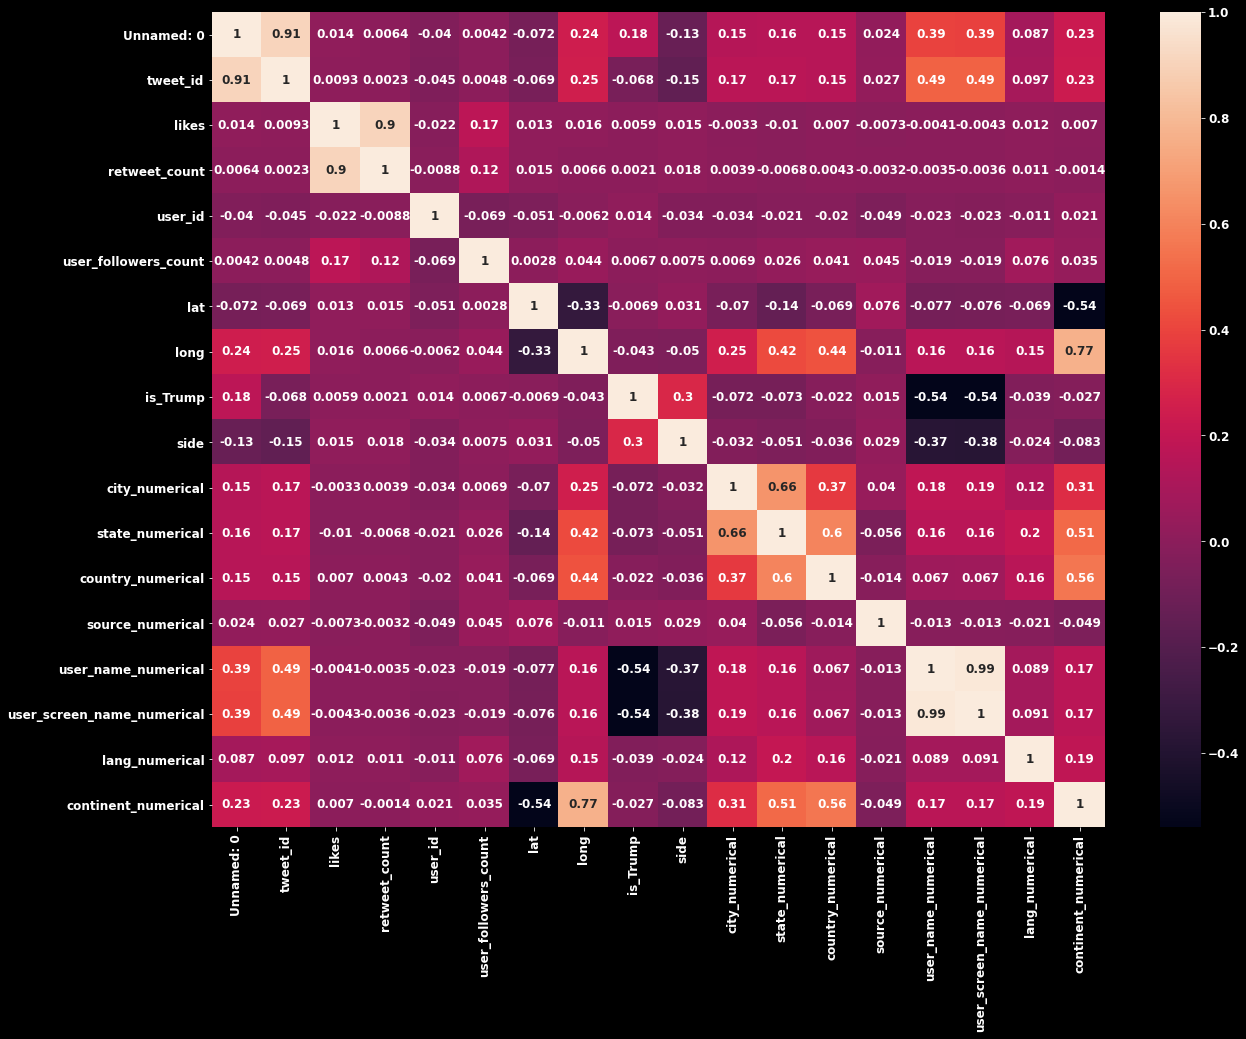

In [ ]:
plt.subplots(figsize=(20,15))
sns.heatmap(Both.corr(), annot = True)
plt.show()

#Result Visualizations

In [ ]:
biden_sentiment = pd.read_csv('/content/drive/MyDrive/301project/Biden_Sentiment.csv',sep='\t')
trump_sentiment = pd.read_csv('/content/drive/MyDrive/301project/Trump_Sentiment.csv',sep='\t')
combined_sentiment = pd.concat([trump_sentiment,biden_sentiment])
biden_sentiment['lemma_sentiment'] = biden_sentiment['lemma_sentiment'].apply(lambda x : round(x,2))
trump_sentiment['lemma_sentiment'] = trump_sentiment['lemma_sentiment'].apply(lambda x : round(x,2))
combined_sentiment['lemma_sentiment'] = combined_sentiment['lemma_sentiment'].apply(lambda x : round(x,2))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Distribution of sentiment

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.760e+02, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 3.000e+01,
        6.000e+00, 7.000e+00, 0.000e+00, 0.000e+00, 3.510e+02, 4.000e+00,
        3.300e+01, 9.000e+00, 4.700e+01, 3.650e+02, 3.300e+01, 3.800e+01,
        6.200e+01, 1.070e+02, 3.340e+02, 2.800e+01, 5.700e+01, 4.900e+01,
        2.700e+01, 1.829e+03, 9.000e+01, 1.370e+02, 7.900e+01, 2.330e+02,
        1.252e+03, 2.270e+02, 3.670e+02, 3.950e+02, 1.126e+03, 2.270e+02,
        6.000e+02, 9.650e+02, 5.570e+02, 1.482e+03, 5.200e+02, 1.075e+03,
        1.174e+03, 5.840e+02, 2.385e+03, 1.034e+03, 1.293e+03, 1.122e+03,
        1.306e+03, 1.194e+03, 1.161e+03, 1.937e+03, 2.391e+03, 2.407e+03,
        4.527e+03, 1.799e+03, 3.442e+03, 1.117e+03, 2.310e+03, 1.138e+03,
        6.203e+03, 1.449e+03, 2.769e+03, 1.442e+03, 3.180e+03, 9.280e+02,
        1.292e+03, 1.858e+03, 1.276e+03, 3.306e+03, 1.930e+02, 1.021e+03,
        8.540e+02, 8.550e+02, 2.840e+02, 3.506e+03, 7.660e+02, 4.360e+02,
        4.690e+02, 1.158e+03, 1.930e+0

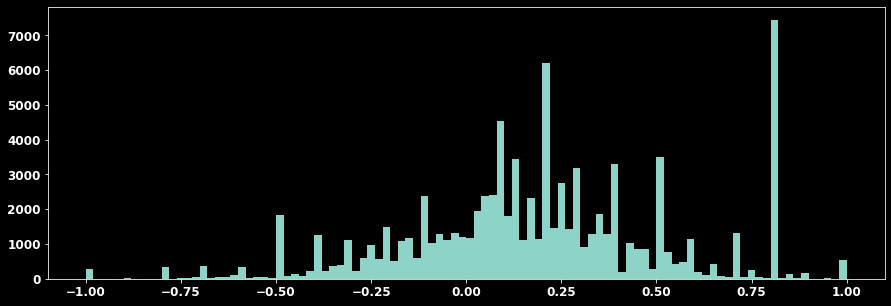

In [ ]:
# Biden DF
plt.subplots(figsize=(15,5))
plt.hist(biden_sentiment.loc[biden_sentiment['lemma_sentiment'] != 0]['lemma_sentiment'],bins=100)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([5.390e+02, 0.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 7.000e+01,
        3.100e+01, 1.300e+01, 3.000e+00, 2.000e+00, 9.210e+02, 8.000e+00,
        8.900e+01, 8.000e+00, 8.400e+01, 6.920e+02, 7.900e+01, 9.300e+01,
        2.200e+01, 1.600e+02, 7.510e+02, 8.200e+01, 1.770e+02, 1.160e+02,
        7.400e+01, 2.444e+03, 2.300e+02, 2.800e+02, 1.340e+02, 3.400e+02,
        2.052e+03, 4.730e+02, 7.530e+02, 9.170e+02, 1.874e+03, 3.390e+02,
        7.660e+02, 1.660e+03, 1.231e+03, 2.561e+03, 8.680e+02, 1.587e+03,
        1.837e+03, 1.068e+03, 4.925e+03, 1.648e+03, 2.064e+03, 1.707e+03,
        1.895e+03, 1.585e+03, 1.718e+03, 2.284e+03, 3.090e+03, 3.207e+03,
        5.943e+03, 2.430e+03, 4.031e+03, 1.499e+03, 2.755e+03, 1.519e+03,
        9.649e+03, 1.772e+03, 3.231e+03, 1.438e+03, 3.470e+03, 8.950e+02,
        1.592e+03, 1.951e+03, 1.413e+03, 3.060e+03, 1.470e+02, 9.920e+02,
        7.320e+02, 6.260e+02, 2.490e+02, 3.907e+03, 4.730e+02, 3.490e+02,
        3.790e+02, 1.110e+03, 1.370e+0

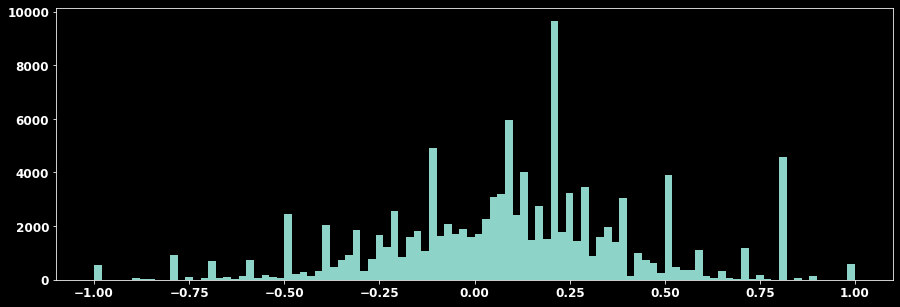

In [ ]:
# Trump DF
plt.subplots(figsize=(15,5))
plt.hist(trump_sentiment.loc[trump_sentiment['lemma_sentiment'] != 0]['lemma_sentiment'],bins=100)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([8.1500e+02, 0.0000e+00, 2.0000e+00, 4.0000e+00, 0.0000e+00,
        1.0000e+02, 3.7000e+01, 2.0000e+01, 3.0000e+00, 2.0000e+00,
        1.2720e+03, 1.2000e+01, 1.2200e+02, 1.7000e+01, 1.3100e+02,
        1.0570e+03, 1.1200e+02, 1.3100e+02, 8.4000e+01, 2.6700e+02,
        1.0850e+03, 1.1000e+02, 2.3400e+02, 1.6500e+02, 1.0100e+02,
        4.2730e+03, 3.2000e+02, 4.1700e+02, 2.1300e+02, 5.7300e+02,
        3.3040e+03, 7.0000e+02, 1.1200e+03, 1.3120e+03, 3.0000e+03,
        5.6600e+02, 1.3660e+03, 2.6250e+03, 1.7880e+03, 4.0430e+03,
        1.3880e+03, 2.6620e+03, 3.0110e+03, 1.6520e+03, 7.3100e+03,
        2.6820e+03, 3.3570e+03, 2.8290e+03, 3.2010e+03, 2.7790e+03,
        2.8790e+03, 4.2210e+03, 5.4810e+03, 5.6140e+03, 1.0470e+04,
        4.2290e+03, 7.4730e+03, 2.6160e+03, 5.0650e+03, 2.6570e+03,
        1.5852e+04, 3.2210e+03, 6.0000e+03, 2.8800e+03, 6.6500e+03,
        1.8230e+03, 2.8840e+03, 3.8090e+03, 2.6890e+03, 6.3660e+03,
        3.4000e+02, 2.0130e+03, 1.5860e+03, 1.48

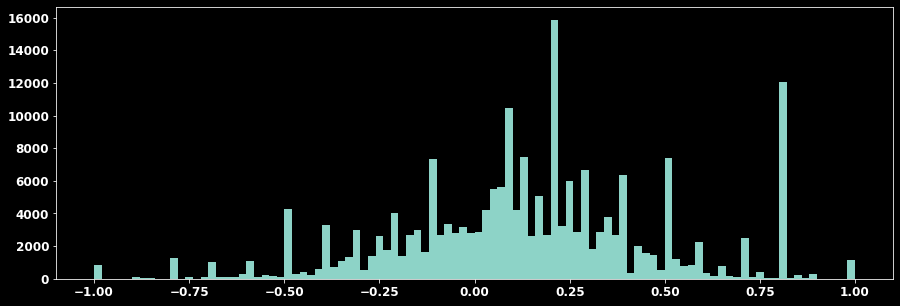

In [ ]:
# Both
plt.subplots(figsize=(15,5))
plt.hist(combined_sentiment.loc[combined_sentiment['lemma_sentiment'] != 0]['lemma_sentiment'],bins=100)

In [ ]:
combined_sentiment = combined_sentiment.dropna()
combined_sentiment = create_numerical_column(combined_sentiment, 'state')
combined_sentiment = create_numerical_column(combined_sentiment, 'city')
combined_sentiment = create_numerical_column(combined_sentiment, 'country')
combined_sentiment = create_numerical_column(combined_sentiment, 'source')
combined_sentiment = create_numerical_column(combined_sentiment, 'user_name')
combined_sentiment = create_numerical_column(combined_sentiment, 'user_screen_name')
combined_sentiment = create_numerical_column(combined_sentiment, 'lang')
combined_sentiment = create_numerical_column(combined_sentiment, 'continent')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


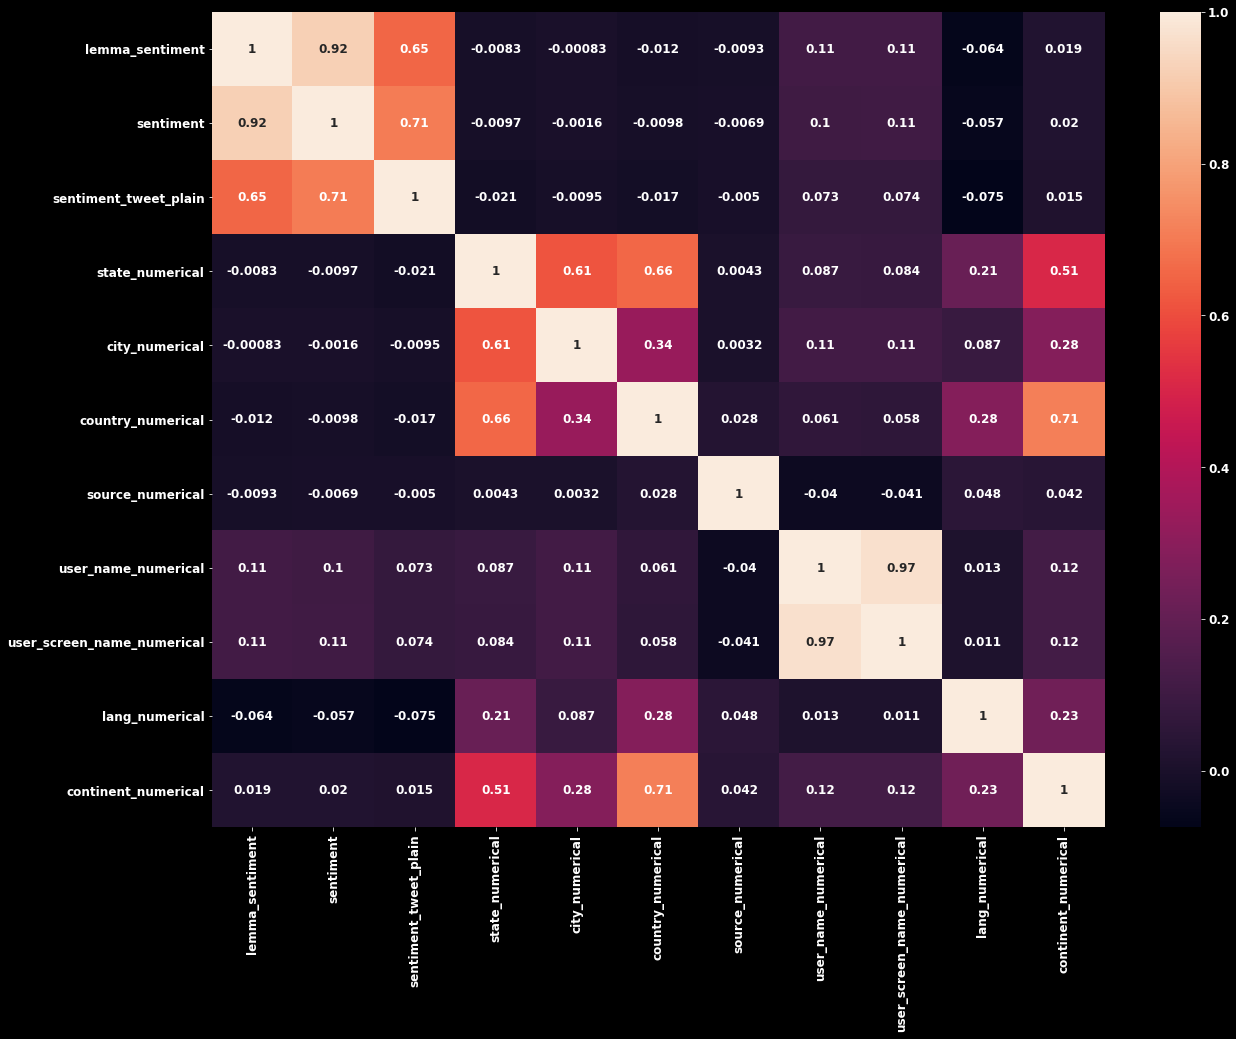

In [ ]:
plt.subplots(figsize=(20,15))
sns.heatmap(combined_sentiment.corr(), annot = True)
plt.show()